# MASH analysis -- AR Water Age Project

In [1]:
# install.packages('pheatmap')
library(ggplot2); packageVersion("ggplot2")
library(tidyr)
library(tibble)
library(dplyr)
library(vegan); packageVersion("vegan")
library(scales)
library(repr)
library(viridis)
library(pheatmap)
library(googlesheets4)
library(googledrive)
library(tidyverse)

[1] ‘3.3.6’


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



[1] ‘2.6.4’

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal



Attaching package: ‘googledrive’


The following objects are masked from ‘package:googlesheets4’:

    request_generate, request_make


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   2.1.2     ✔ stringr 1.4.1
✔ purrr   0.3.4     ✔ forcats 0.5.2

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor()             masks scales::col_factor()
✖ purrr::discard()                masks scales::discard()
✖ dplyr::filter()                 masks stats::filter()
✖ dplyr::lag()                    masks stats::lag()
✖ googledrive::request_generate() masks googlesheets4::request_generate()
✖ googledrive::request_make()     masks googlesheets4::request_make()



In [3]:
fig_dir <- '/Users/hannahgreenwald/Documents/Documents/Berkeley_Research/AR_metagenomics/figures/'

In [4]:
#metadata from google sheets
drive_auth(path="/Users/hannahgreenwald/Documents/Documents/Berkeley_Research/DPR_AR_Research/AR-Water-Quality-Data/access-to-jupyter-21919fd4c701.json", cache=TRUE)
gs4_auth(path="/Users/hannahgreenwald/Documents/Documents/Berkeley_Research/DPR_AR_Research/AR-Water-Quality-Data/access-to-jupyter-21919fd4c701.json")


In [5]:
#import dfs 
master_sampling <- drive_get("AR MasterDataSheet") 
id2code <- master_sampling %>% read_sheet(sheet= "ggkbase_names")
arbf <- master_sampling %>% read_sheet(sheet= "ARBF_data")
# ar_trimmed <- read.table(file = "/Users/hannahgreenwald/Documents/Documents/Berkeley_Research/DPR_AR_Research/AR-Water-Quality-Data/ar_trimmed.tsv", header= TRUE, row.names=NULL, sep="\t")
# bf_trimmed <- read.table(file = "/Users/hannahgreenwald/Documents/Documents/Berkeley_Research/DPR_AR_Research/AR-Water-Quality-Data/biofilm_trimmed.tsv", header= TRUE, row.names=NULL, sep="\t")


✔ The input `path` resolved to exactly 1 file.

✔ Reading from AR MasterDataSheet.

✔ Range ''ggkbase_names''.

✔ Reading from AR MasterDataSheet.

✔ Range ''ARBF_data''.



In [6]:
#merge metadata sheets together 
# ar_full <- merge( ar_trimmed,bf_trimmed, by= c("sample_id_old", "AR", "type", "sampling_event", "shear_rpm", "replicate", "sampling_week"), all= TRUE)
metadata <- merge(arbf, id2code, by= "sample_id")

head(metadata)


,sample_id,ARBF,type,day,sample_id_old.x,month_date,sample_date,sampling_week,AR_num,AR,⋯,bf_ATPi_avg_nmol.cm2,ATPe_avg_nM,ATPi_avg_nM,flow_rate_mL.min,residence_time_h,length.cm,8/27/2019,9/30/2019,sample_id_old.y,ggkbase_project_name
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dttm>,<dttm>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>,<chr>
1,AR1_134,AR,AR,134,AR_1_23,2020-02-01,2020-02-11,20,1,AR1,⋯,NA,0.001098028,0.0003232049,1.860,NA,NA,NA,NA,AR_1_23,ARSTAG_AR_1_23
2,AR1_162,AR,AR,162,AR_1_27,2020-03-01,2020-03-10,24,1,AR1,⋯,NA,0.001709529,0.0001174805,2.071,NA,NA,NA,NA,AR_1_27,ARSTAG_AR_1_27
3,AR1_372,AR,AR,372,AR_1_40,2020-10-01,2020-10-06,54,1,AR1,⋯,NA,0.009120520,0.1112846998,NA,NA,NA,NA,NA,AR_1_40,ARSTAG_AR_1_40
4,AR1_387,AR,AR,387,AR_1_41,2020-10-01,2020-10-21,56,1,AR1,⋯,NA,0.001664647,0.0619132746,NA,NA,NA,NA,NA,AR_1_41,ARSTAG_AR_1_41
5,AR2_134,AR,AR,134,AR_2_23,2020-02-01,2020-02-11,20,2,AR2,⋯,NA,0.001476281,0.0074578233,1.880,NA,NA,NA,NA,AR_2_23,ARSTAG_AR_2_23
6,AR2_162,AR,AR,162,AR_2_27,2020-03-01,2020-03-10,24,2,AR2,⋯,NA,0.002092722,0.0086160839,2.084,NA,NA,NA,NA,AR_2_27,ARSTAG_AR_2_27


# MASH distances with reads

In [7]:
dist <- read.table('~/Documents/Documents/Berkeley_Research/AR_metagenomics/arstag_mashdist.csv', sep='\t',
                   col.names = c('query', 'ref', 'distance', 'pval', 'matching_hashes'))

dist$distance <- as.numeric(dist$distance)

dist2 <- merge(dist, id2code, by.x='query', by.y='ggkbase_project_name')
dist2 <- merge(dist2, id2code, by.x='ref', by.y='ggkbase_project_name')
dist2 <- dist2 %>% select('sample_id.x', 'sample_id.y', 'distance', 'pval', 'matching_hashes') %>% dplyr::rename("ref"="sample_id.x")  %>% dplyr::rename("query"="sample_id.y") 

# metadata <- read.table('~/data/awtp2_metagenomics/metagenomics_sample_table.tsv', sep='\t', header = TRUE)
# # get a lookup of sample_id to sample_code:
# id2code <- metadata[,c('sample_id', 'sample_code_partial')]

head(dist2)
# head(id2code)

,ref,query,distance,pval,matching_hashes
,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,AR1_134,AR1_134,0.0000000,0,10000/10000
2,AR1_162,AR1_134,0.0199449,0,4901/10000
3,AR3_387,AR1_134,0.0406685,0,2704/10000
4,AR1_372,AR1_134,0.0365270,0,3024/10000
5,AR1_387,AR1_134,0.0379128,0,2912/10000
6,AR5_387,AR1_134,0.0428354,0,2553/10000


In [8]:
# # get sample names for plotting
df <- merge(dist, metadata, by.x='query', by.y='ggkbase_project_name')
df <- merge(df, metadata, by.x='ref', by.y='ggkbase_project_name')

df <- df[order(df$sample_id.x, df$sample_id.y),] # sort df



In [9]:
head(df)
colnames(df)
length(df)
head(dist2)
head(dist)

,ref,query,distance,pval,matching_hashes,sample_id.x,ARBF.x,type.x,day.x,sample_id_old.x.x,⋯,bf_ATPe_avg_nmol.cm2.y,bf_ATPi_avg_nmol.cm2.y,ATPe_avg_nM.y,ATPi_avg_nM.y,flow_rate_mL.min.y,residence_time_h.y,length.cm.y,8/27/2019.y,9/30/2019.y,sample_id_old.y.y
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>
1,ARSTAG_AR_1_23,ARSTAG_AR_1_23,0.0000000,0,10000/10000,AR1_134,AR,AR,134,AR_1_23,⋯,NA,NA,0.001098028,0.0003232049,1.860,NA,NA,NA,NA,AR_1_23
80,ARSTAG_AR_1_27,ARSTAG_AR_1_23,0.0199449,0,4901/10000,AR1_134,AR,AR,134,AR_1_23,⋯,NA,NA,0.001709529,0.0001174805,2.071,NA,NA,NA,NA,AR_1_27
118,ARSTAG_AR_1_40,ARSTAG_AR_1_23,0.0365270,0,3024/10000,AR1_134,AR,AR,134,AR_1_23,⋯,NA,NA,0.009120520,0.1112846998,NA,NA,NA,NA,NA,AR_1_40
163,ARSTAG_AR_1_41,ARSTAG_AR_1_23,0.0379128,0,2912/10000,AR1_134,AR,AR,134,AR_1_23,⋯,NA,NA,0.001664647,0.0619132746,NA,NA,NA,NA,NA,AR_1_41
221,ARSTAG_AR_2_23,ARSTAG_AR_1_23,0.0241755,0,4305/10000,AR1_134,AR,AR,134,AR_1_23,⋯,NA,NA,0.001476281,0.0074578233,1.880,NA,NA,NA,NA,AR_2_23
266,ARSTAG_AR_2_27,ARSTAG_AR_1_23,0.0236626,0,4372/10000,AR1_134,AR,AR,134,AR_1_23,⋯,NA,NA,0.002092722,0.0086160839,2.084,NA,NA,NA,NA,AR_2_27


[1] "ref"                     "query"                  
  [3] "distance"                "pval"                   
  [5] "matching_hashes"         "sample_id.x"            
  [7] "ARBF.x"                  "type.x"                 
  [9] "day.x"                   "sample_id_old.x.x"      
 [11] "month_date.x"            "sample_date.x"          
 [13] "sampling_week.x"         "AR_num.x"               
 [15] "AR.x"                    "phase.x"                
 [17] "replicate.x"             "sampling_event.x"       
 [19] "water_use.x"             "extr_date.x"            
 [21] "extr_notes.x"            "qubit_clean.x"          
 [23] "qubit_nguL.x"            "sterivex_date.x"        
 [25] "sterivex_filtered_vol.x" "bf_total_homog_vol.x"   
 [27] "shear_rpm.x"             "pH.x"                   
 [29] "conductivity.x"          "DO.x"                   
 [31] "temp.x"                  "cl_total.x"             
 [33] "cl_free.x"               "FCM_vol.x"              
 [35] "TCC1.x"                  "TCC2.x"                 
 [37] "TCC3.x"                  "ICC1.x"                 
 [39] "ICC2.x"                  "ICC3.x"                 
 [41] "FCM_dilution.x"          "ICC_avg.x"              
 [43] "TCC_avg.x"               "ICC_cells.mL.x"         
 [45] "TCC_cells.mL.x"          "bf_fcm_dilution.x"      
 [47] "bf_TCC1.x"               "bf_TCC2.x"              
 [49] "bf_TCC3.x"               "bf_ICC1.x"              
 [51] "bf_ICC2.x"               "bf_ICC3.x"              
 [53] "bf_TCC_avg.x"            "bf_ICCavg (cells/mL).x" 
 [55] "ATPt1.x"                 "ATPt2.x"                
 [57] "ATPt3.x"                 "bf_ATPt_avg_nmol.cm2.x" 
 [59] "ATPt_std_RLU.x"          "ATPt_avg_RLU.x"         
 [61] "ATPt_avg_nM.x"           "ATPe1.x"                
 [63] "ATPe2.x"                 "ATPe3.x"                
 [65] "ATPe_avg_RLU.x"          "bf_ATPe_avg_nmol.cm2.x" 
 [67] "bf_ATPi_avg_nmol.cm2.x"  "ATPe_avg_nM.x"          
 [69] "ATPi_avg_nM.x"           "flow_rate_mL.min.x"     
 [71] "residence_time_h.x"      "length.cm.x"            
 [73] "8/27/2019.x"             "9/30/2019.x"            
 [75] "sample_id_old.y.x"       "sample_id.y"            
 [77] "ARBF.y"                  "type.y"                 
 [79] "day.y"                   "sample_id_old.x.y"      
 [81] "month_date.y"            "sample_date.y"          
 [83] "sampling_week.y"         "AR_num.y"               
 [85] "AR.y"                    "phase.y"                
 [87] "replicate.y"             "sampling_event.y"       
 [89] "water_use.y"             "extr_date.y"            
 [91] "extr_notes.y"            "qubit_clean.y"          
 [93] "qubit_nguL.y"            "sterivex_date.y"        
 [95] "sterivex_filtered_vol.y" "bf_total_homog_vol.y"   
 [97] "shear_rpm.y"             "pH.y"                   
 [99] "conductivity.y"          "DO.y"                   
[101] "temp.y"                  "cl_total.y"             
[103] "cl_free.y"               "FCM_vol.y"              
[105] "TCC1.y"                  "TCC2.y"                 
[107] "TCC3.y"                  "ICC1.y"                 
[109] "ICC2.y"                  "ICC3.y"                 
[111] "FCM_dilution.y"          "ICC_avg.y"              
[113] "TCC_avg.y"               "ICC_cells.mL.y"         
[115] "TCC_cells.mL.y"          "bf_fcm_dilution.y"      
[117] "bf_TCC1.y"               "bf_TCC2.y"              
[119] "bf_TCC3.y"               "bf_ICC1.y"              
[121] "bf_ICC2.y"               "bf_ICC3.y"              
[123] "bf_TCC_avg.y"            "bf_ICCavg (cells/mL).y" 
[125] "ATPt1.y"                 "ATPt2.y"                
[127] "ATPt3.y"                 "bf_ATPt_avg_nmol.cm2.y" 
[129] "ATPt_std_RLU.y"          "ATPt_avg_RLU.y"         
[131] "ATPt_avg_nM.y"           "ATPe1.y"                
[133] "ATPe2.y"                 "ATPe3.y"                
[135] "ATPe_avg_RLU.y"          "bf_ATPe_avg_nmol.cm2.y" 
[137] "bf_ATPi_avg_nmol.cm2.y"  "ATPe_avg_nM.y"          


[1] 145

,ref,query,distance,pval,matching_hashes
,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,AR1_134,AR1_134,0.0000000,0,10000/10000
2,AR1_162,AR1_134,0.0199449,0,4901/10000
3,AR3_387,AR1_134,0.0406685,0,2704/10000
4,AR1_372,AR1_134,0.0365270,0,3024/10000
5,AR1_387,AR1_134,0.0379128,0,2912/10000
6,AR5_387,AR1_134,0.0428354,0,2553/10000


,query,ref,distance,pval,matching_hashes
,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,ARSTAG_AR_1_23,ARSTAG_AR_1_23,0.0000000,0,10000/10000
2,ARSTAG_AR_1_27,ARSTAG_AR_1_23,0.0199449,0,4901/10000
3,ARSTAG_AR_1_40,ARSTAG_AR_1_23,0.0365270,0,3024/10000
4,ARSTAG_AR_1_41,ARSTAG_AR_1_23,0.0379128,0,2912/10000
5,ARSTAG_AR_2_23,ARSTAG_AR_1_23,0.0241755,0,4305/10000
6,ARSTAG_AR_2_27,ARSTAG_AR_1_23,0.0236626,0,4372/10000


## Basic Heatmap

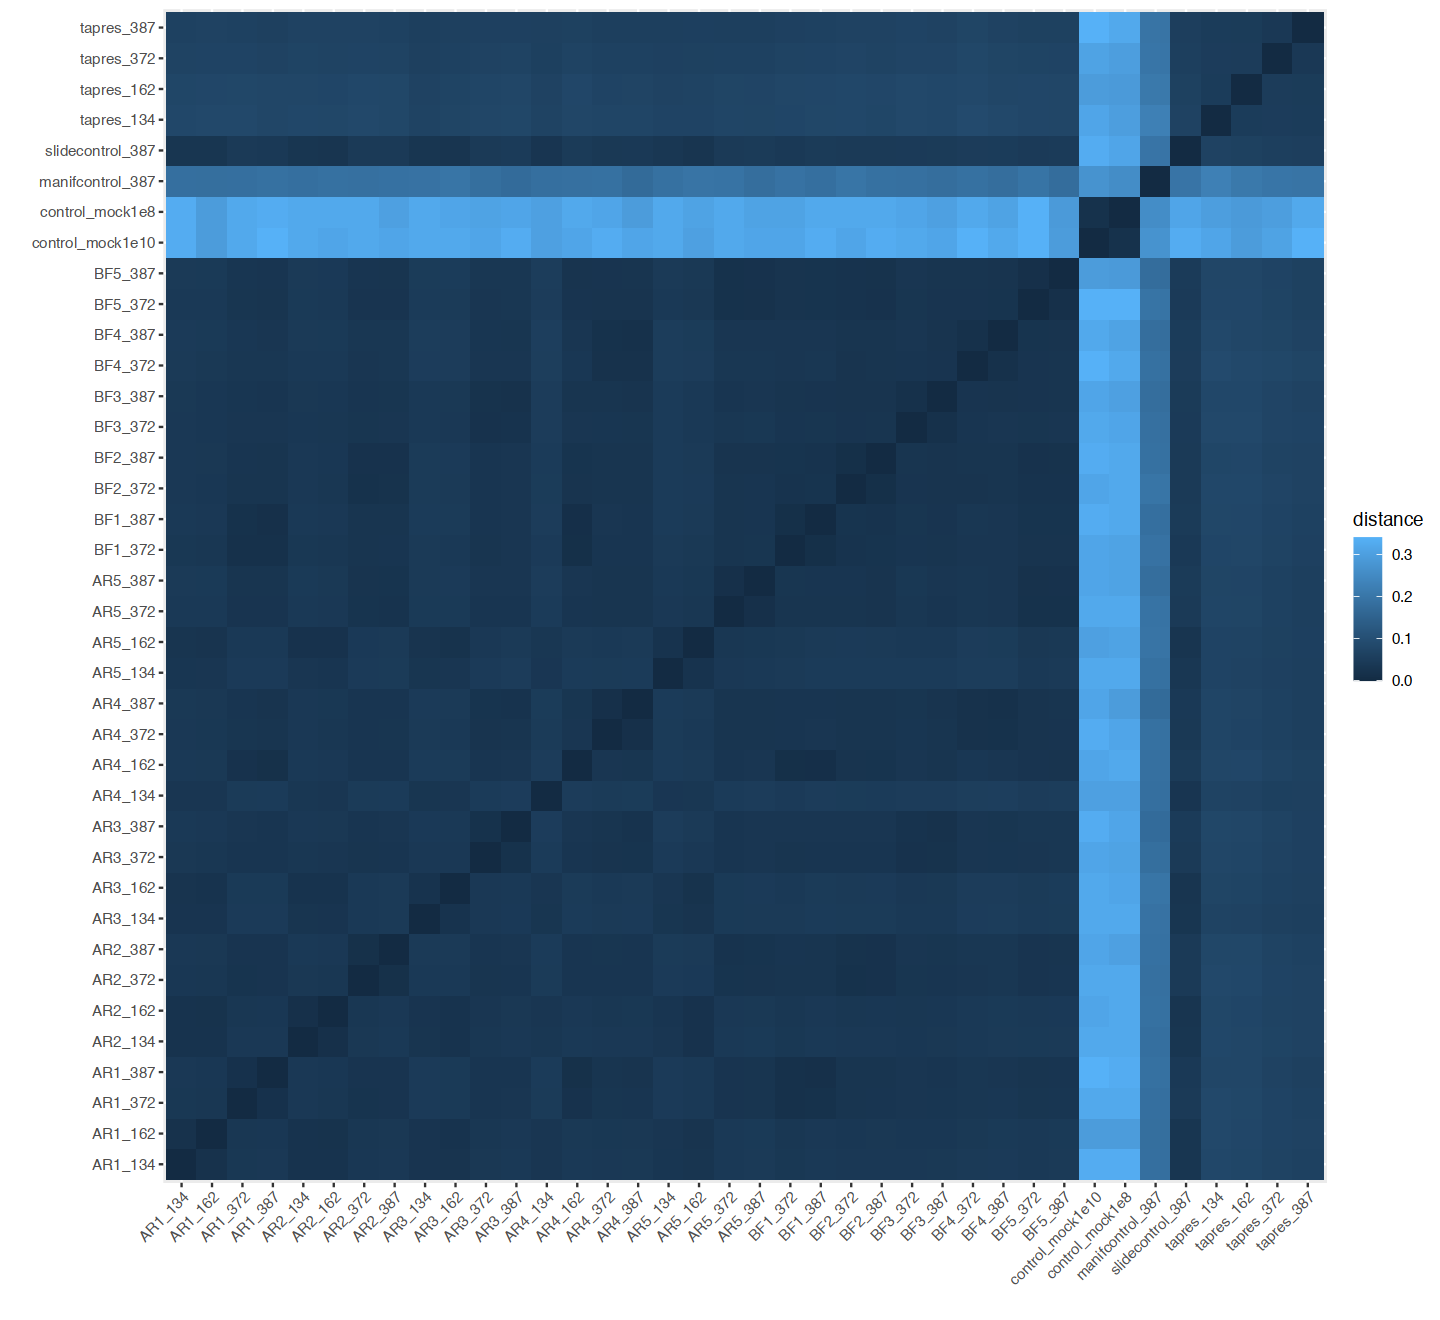

In [10]:
options(repr.plot.width = 12, repr.plot.height = 11)

ggplot(df, aes(x=sample_id.x, y=sample_id.y))+
    geom_tile(aes(fill=distance))+
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    xlab('') + 
    ylab('')

# ggsave('~/data/awtp2_metagenomics/mash_dist_heatmap.pdf', device="pdf", width=7, height=5.5)

## Clustered Heatmap

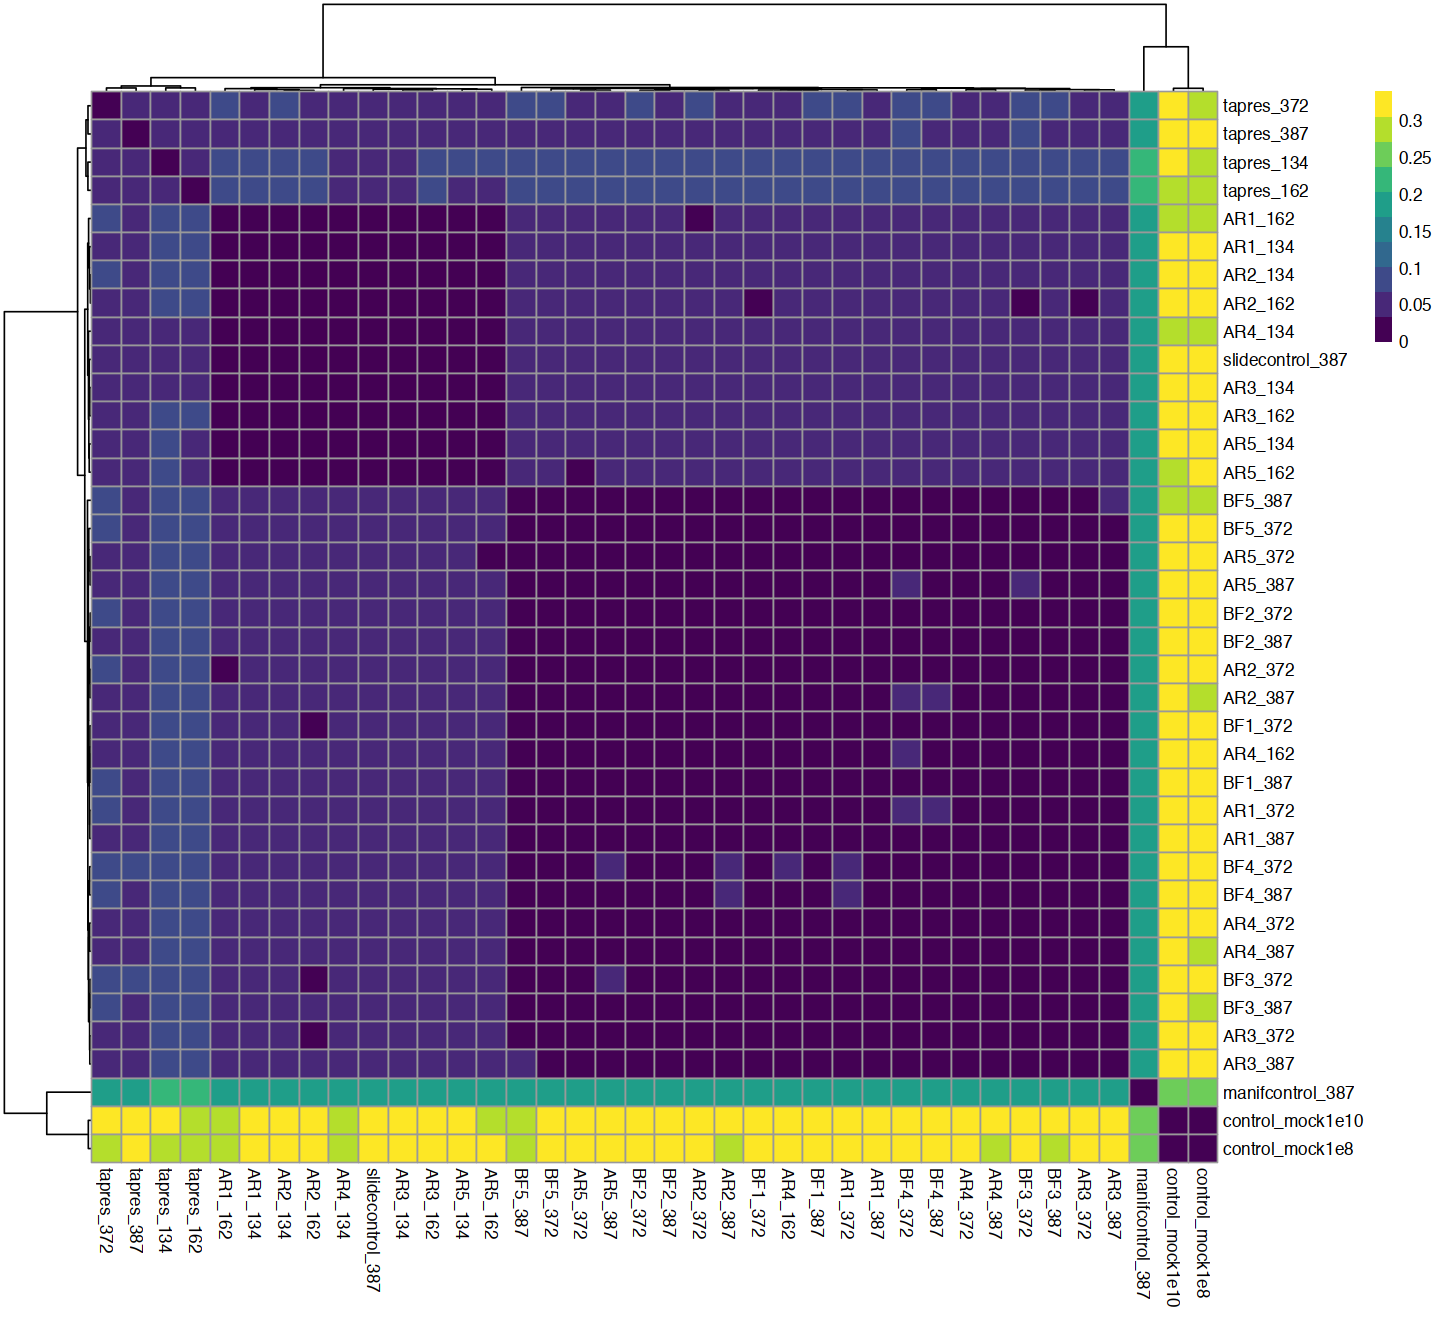

In [11]:
#subset selected columns
df2 <- dist2[c('query', 'ref', 'distance')]
#reformat table to wide
df_wide <- df2 %>% spread(ref, distance) %>% column_to_rownames('query')
#heatplus requires a matrix not a dataframe
m <- as.matrix(df_wide)
options(repr.plot.width = 12, repr.plot.height = 11)
pheatmap(m, color=viridis(10))
# pheatmap(m, color=viridis(10), filename='~/data/awtp2_metagenomics/mash_dist_clustered_heatmap.pdf')


# MASH distances without mock

In [12]:
dist <- read.table('~/Documents/Documents/Berkeley_Research/AR_metagenomics/arstag_mashdist_nomock.csv', sep='\t',
                   col.names = c('query', 'ref', 'distance', 'pval', 'matching_hashes'))

dist$distance <- as.numeric(dist$distance)

head(dist)

,query,ref,distance,pval,matching_hashes
,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,ARSTAG_AR_1_23,ARSTAG_AR_1_23,0.0000000,0,10000/10000
2,ARSTAG_AR_1_27,ARSTAG_AR_1_23,0.0199449,0,4901/10000
3,ARSTAG_AR_1_40,ARSTAG_AR_1_23,0.0365270,0,3024/10000
4,ARSTAG_AR_1_41,ARSTAG_AR_1_23,0.0379128,0,2912/10000
5,ARSTAG_AR_2_23,ARSTAG_AR_1_23,0.0241755,0,4305/10000
6,ARSTAG_AR_2_27,ARSTAG_AR_1_23,0.0236626,0,4372/10000


In [13]:
# # get sample names for plotting
df <- merge(dist, metadata, by.x='query', by.y='ggkbase_project_name')
df <- merge(df, metadata, by.x='ref', by.y='ggkbase_project_name')
df <- df[order(df$sample_id.x, df$sample_id.y),] # sort df


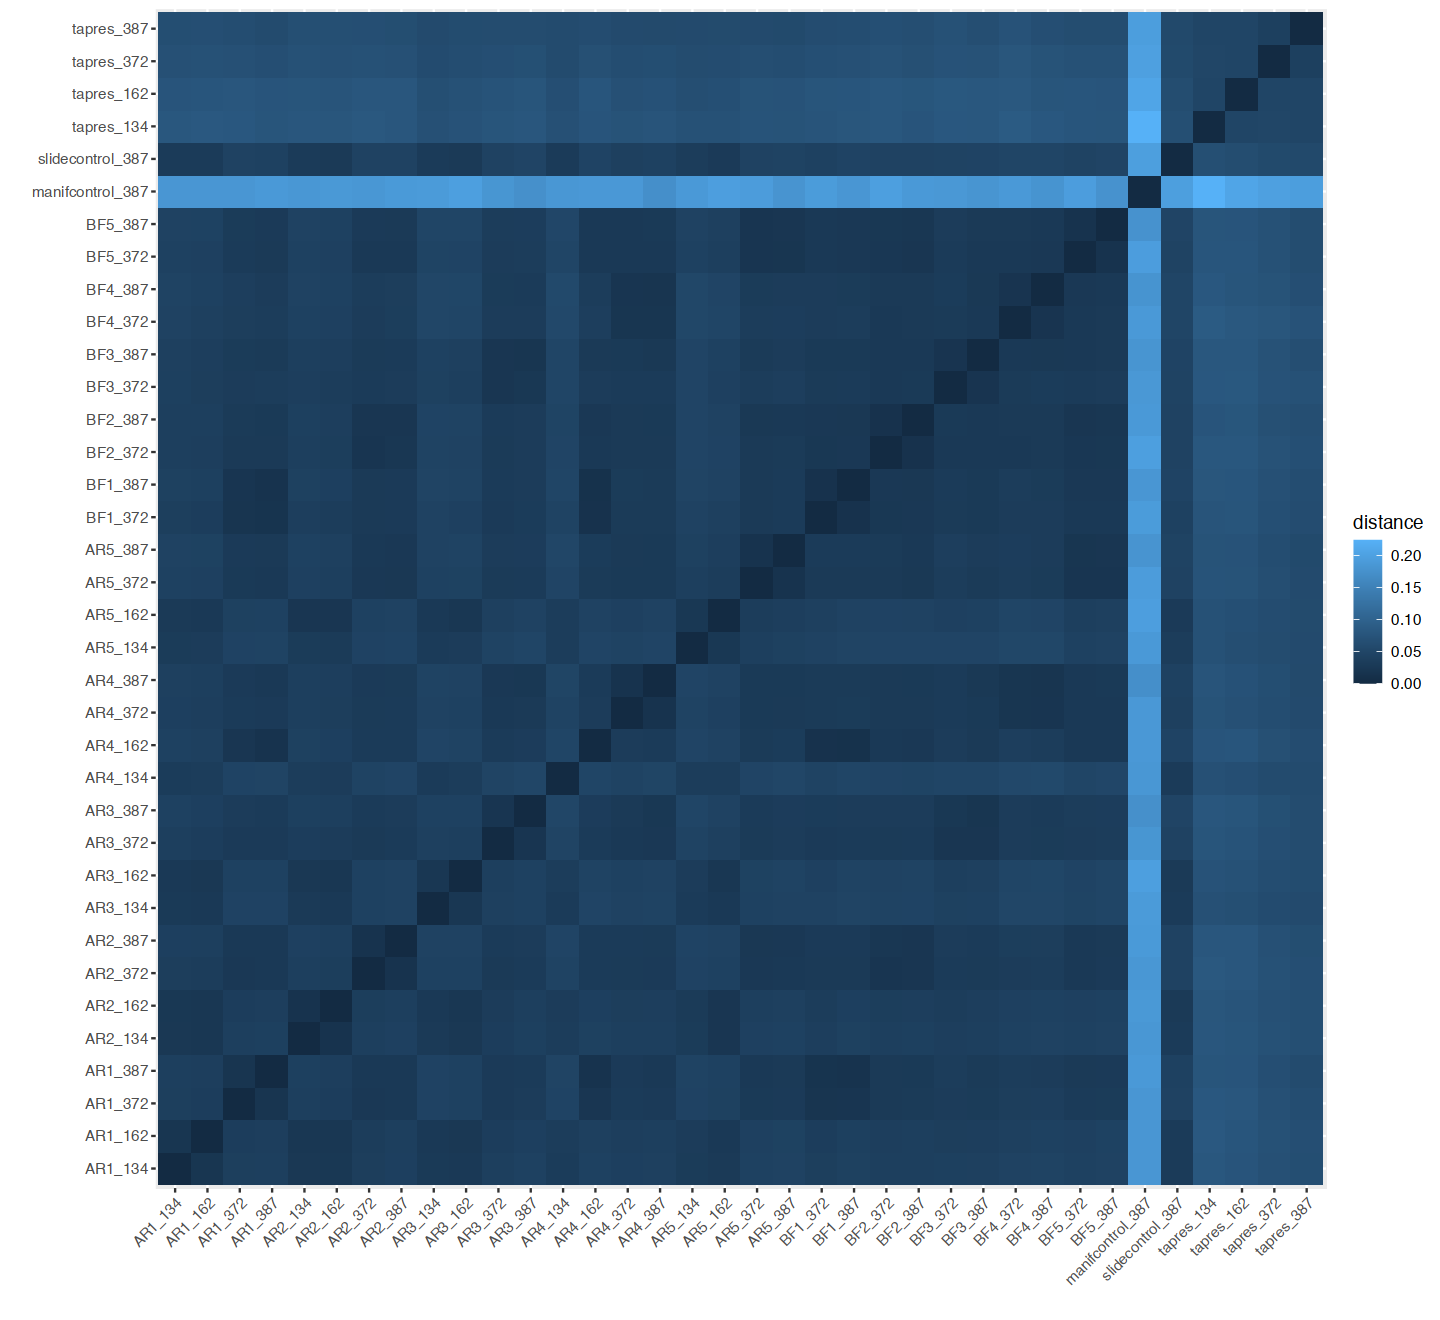

In [14]:
options(repr.plot.width = 12, repr.plot.height = 11)

ggplot(df, aes(x=sample_id.x, y=sample_id.y))+
    geom_tile(aes(fill=distance))+
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    xlab('') + 
    ylab('')

# ggsave('~/data/awtp2_metagenomics/mash_dist_heatmap.pdf', device="pdf", width=7, height=5.5)

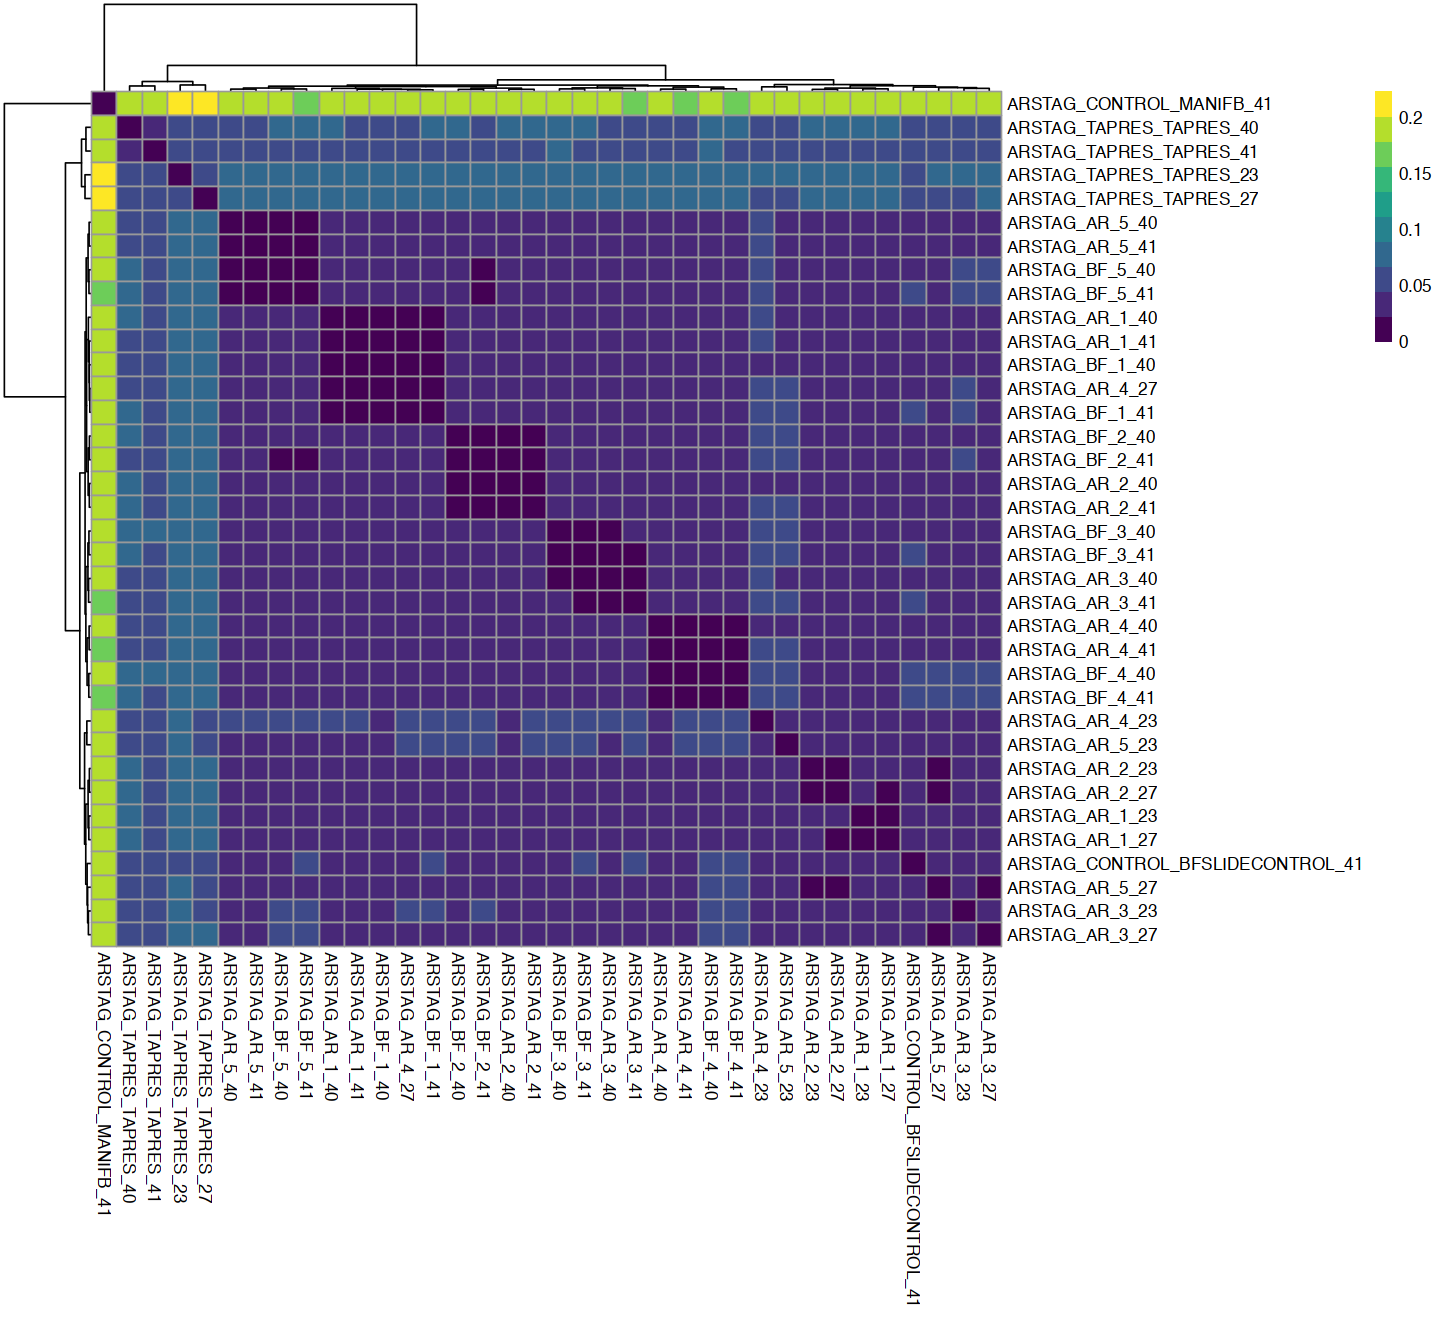

In [15]:
#subset selected columns
df2 <- dist[c('query', 'ref', 'distance')]
#reformat table to wide
df_wide <- df2 %>% spread(ref, distance) %>% column_to_rownames('query')
#heatplus requires a matrix not a dataframe
m <- as.matrix(df_wide)
options(repr.plot.width = 12, repr.plot.height = 11)
pheatmap(m, color=viridis(10))
# pheatmap(m, color=viridis(10), filename='~/data/awtp2_metagenomics/mash_dist_clustered_heatmap.pdf')


In [16]:
# #subset selected columns
# df2 <- dist[c('query', 'ref', 'distance')] %>% subset(query != "ARSTAG_CONTROL_MANIFB_41") %>% subset(ref != "ARSTAG_CONTROL_MANIFB_41") %>%
#  subset(query != "ARSTAG_TAPRES_TAPRES_41") %>% subset(ref != "ARSTAG_TAPRES_TAPRES_41")%>%
#  subset(query != "ARSTAG_TAPRES_TAPRES_40") %>% subset(ref != "ARSTAG_TAPRES_TAPRES_40")%>%
# subset(query != "ARSTAG_TAPRES_TAPRES_23") %>% subset(ref != "ARSTAG_TAPRES_TAPRES_23")%>%
# subset(query != "ARSTAG_TAPRES_TAPRES_27") %>% subset(ref != "ARSTAG_TAPRES_TAPRES_27")

# #reformat table to wide
# df_wide <- df2 %>% spread(ref, distance) %>% column_to_rownames('query')
# #heatplus requires a matrix not a dataframe
# m <- as.matrix(df_wide)
# options(repr.plot.width = 12, repr.plot.height = 11)
# pheatmap(m, color=viridis(10))
# pheatmap(m, color=viridis(10), filename='/Users/hannahgreenwald/Documents/Documents/Berkeley_Research/AR_metagenomics/figures/mash_dist_clustered_heatmap.pdf')


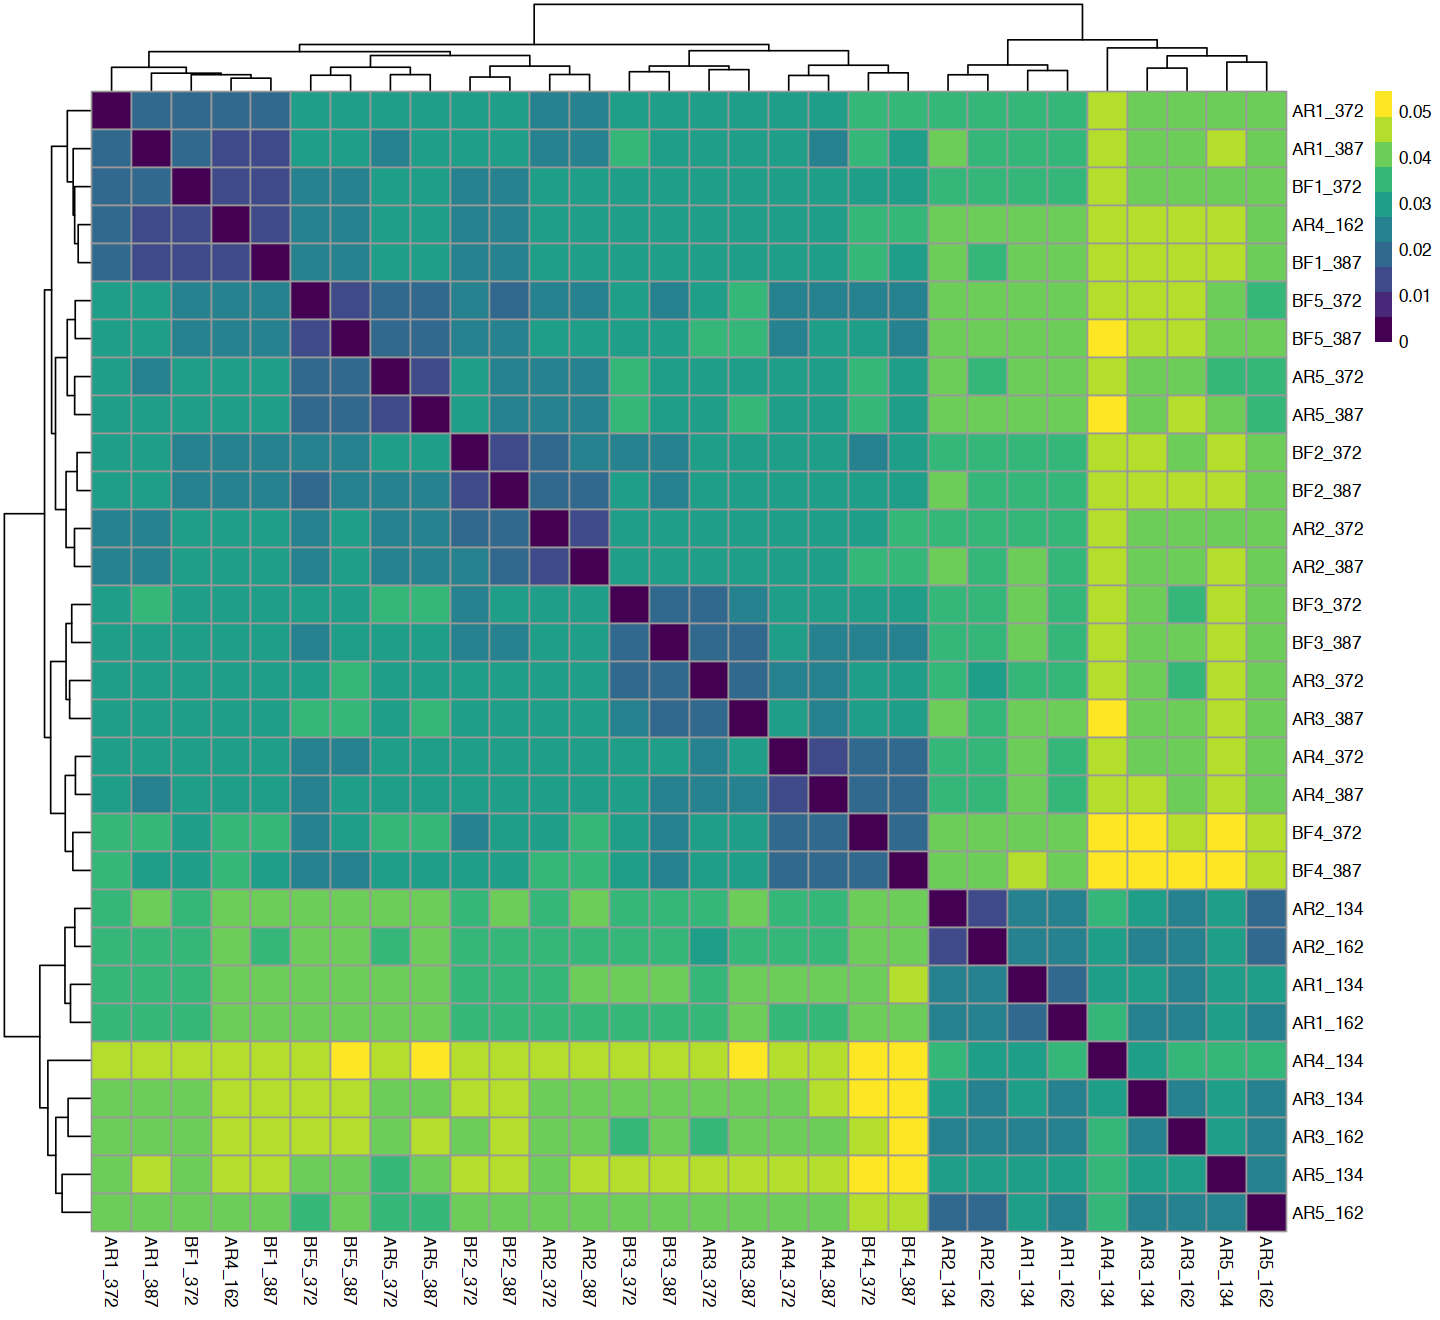

In [17]:
#subset selected columns
df2 <- dist2[c('query', 'ref', 'distance')] %>% subset(query != "manifcontrol_387")%>% subset(ref != "manifcontrol_387")%>% 
subset(query != "slidecontrol_387") %>% subset(ref != "slidecontrol_387") %>%
subset(query != "control_mock1e8") %>% subset(ref != "control_mock1e8") %>%
subset(query != "control_mock1e10") %>% subset(ref != "control_mock1e10") %>%
 subset(query != "tapres_387") %>% subset(ref != "tapres_387")%>%
 subset(query != "tapres_372") %>% subset(ref != "tapres_372")%>%
subset(query != "tapres_134") %>% subset(ref != "tapres_134")%>%
subset(query != "tapres_162") %>% subset(ref != "tapres_162")

#reformat table to wide
df_wide <- df2 %>% spread(ref, distance) %>% column_to_rownames('query')
#heatplus requires a matrix not a dataframe
m <- as.matrix(df_wide)
options(repr.plot.width = 12, repr.plot.height = 11)
pheatmap(m, color=viridis(10))
pheatmap(m, color=viridis(10), filename='/Users/hannahgreenwald/Documents/Documents/Berkeley_Research/AR_metagenomics/figures/mash_dist_clustered_heatmap.pdf')


# Plotting Quality Metrics

In [18]:
#read in quality table post assembly
quality_table <- read.table(file = '/Users/hannahgreenwald/Documents/Documents/Berkeley_Research/AR_metagenomics/quality_table_postass.csv', header= TRUE, row.names=NULL, sep=",")
quality_table["ggkbase_project_name"] <- quality_table$sample_id
# quality_table$sampling_week <- as.character(quality_table$sampling_week)



In [19]:
#merge with metadata
assem_stats <- merge(quality_table, metadata, by='ggkbase_project_name')

In [20]:
colnames(assem_stats)

[1] "ggkbase_project_name"  "X"                     "sample_id.x"          
 [4] "raw_file_F"            "raw_file_R"            "trim_file_F"          
 [7] "trim_file_R"           "raw_num_seq_F"         "raw_num_seq_R"        
[10] "trim_num_seq_F"        "trim_num_seq_R"        "perc_seq_lost_to_trim"
[13] "combined_file"         "N50"                   "scaffold_count"       
[16] "assembly_size"         "sample_id.y"           "ARBF"                 
[19] "type"                  "day"                   "sample_id_old.x"      
[22] "month_date"            "sample_date"           "sampling_week"        
[25] "AR_num"                "AR"                    "phase"                
[28] "replicate"             "sampling_event"        "water_use"            
[31] "extr_date"             "extr_notes"            "qubit_clean"          
[34] "qubit_nguL"            "sterivex_date"         "sterivex_filtered_vol"
[37] "bf_total_homog_vol"    "shear_rpm"             "pH"                   
[40] "conductivity"          "DO"                    "temp"                 
[43] "cl_total"              "cl_free"               "FCM_vol"              
[46] "TCC1"                  "TCC2"                  "TCC3"                 
[49] "ICC1"                  "ICC2"                  "ICC3"                 
[52] "FCM_dilution"          "ICC_avg"               "TCC_avg"              
[55] "ICC_cells.mL"          "TCC_cells.mL"          "bf_fcm_dilution"      
[58] "bf_TCC1"               "bf_TCC2"               "bf_TCC3"              
[61] "bf_ICC1"               "bf_ICC2"               "bf_ICC3"              
[64] "bf_TCC_avg"            "bf_ICCavg (cells/mL)"  "ATPt1"                
[67] "ATPt2"                 "ATPt3"                 "bf_ATPt_avg_nmol.cm2" 
[70] "ATPt_std_RLU"          "ATPt_avg_RLU"          "ATPt_avg_nM"          
[73] "ATPe1"                 "ATPe2"                 "ATPe3"                
[76] "ATPe_avg_RLU"          "bf_ATPe_avg_nmol.cm2"  "bf_ATPi_avg_nmol.cm2" 
[79] "ATPe_avg_nM"           "ATPi_avg_nM"           "flow_rate_mL.min"     
[82] "residence_time_h"      "length.cm"             "8/27/2019"            
[85] "9/30/2019"             "sample_id_old.y"

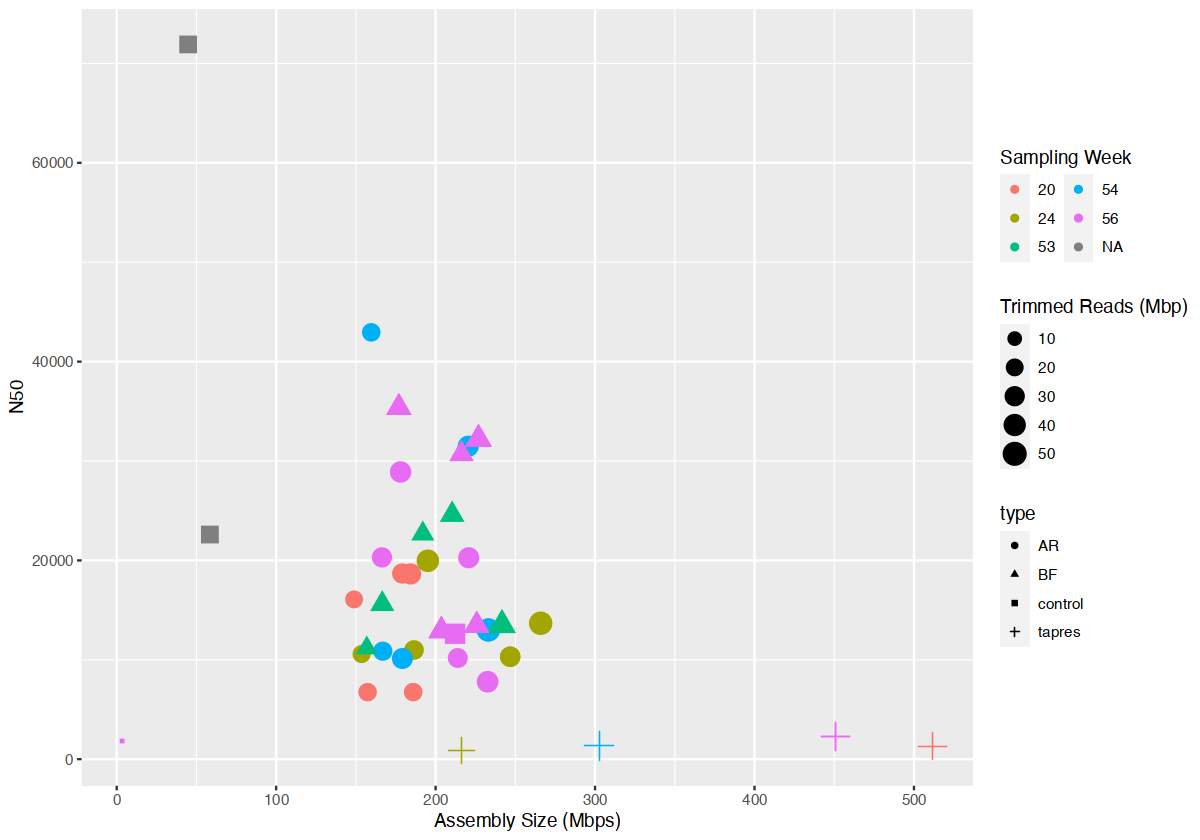

In [21]:
options(repr.plot.width = 10, repr.plot.height = 7)

ggplot(assem_stats, aes(x=assembly_size/1000000, y=N50, size=trim_num_seq_F/1000000, color=as.character(sampling_week), shape= type))+
    geom_point()+
    xlab('Assembly Size (Mbps)')+
    guides(size=guide_legend(ncol = 1, title="Trimmed Reads (Mbp)")) +
    guides(color=guide_legend(ncol = 2, title="Sampling Week")) 

# Coordinate Analysis

In [22]:
library(BiodiversityR)

Loading required package: tcltk

BiodiversityR 2.15-1: Use command BiodiversityRGUI() to launch the Graphical User Interface; 
to see changes use BiodiversityRGUI(changeLog=TRUE, backward.compatibility.messages=TRUE)




In [23]:
dist_nmds <- dist2 %>% filter(query != "slidecontrol_387" & query != "manifcontrol_387" & ref != "slidecontrol_387" & ref != "manifcontrol_387") %>%
                        filter(query != "control_mock1e8" & query != "control_mock1e10" & ref != "control_mock1e8" & ref != "control_mock1e10") %>%
                select(query, ref, distance) %>% pivot_wider(names_from= ref, values_from= distance) 
sample_id <- dist_nmds$query 
rownames(dist_nmds) <- sample_id
dist_nmds <- dist_nmds %>% select(-c(query))

metadata_nmds <- metadata %>% filter(sample_id != "control_mock1e10" &sample_id != "control_mock1e8" &sample_id != "slidecontrol_387" &sample_id != "manifcontrol_387" ) %>%
                filter(replicate == "A")



Warning message:
“Setting row names on a tibble is deprecated.”


Run 0 stress 0.02892886 
Run 1 stress 0.02892884 
... New best solution
... Procrustes: rmse 8.171611e-06  max resid 1.875129e-05 
... Similar to previous best
Run 2 stress 0.02888745 
... New best solution
... Procrustes: rmse 0.001434839  max resid 0.005412515 
... Similar to previous best
Run 3 stress 0.02888741 
... New best solution
... Procrustes: rmse 1.268469e-05  max resid 2.872603e-05 
... Similar to previous best
Run 4 stress 0.02888725 
... New best solution
... Procrustes: rmse 7.671668e-05  max resid 0.0001829126 
... Similar to previous best
Run 5 stress 0.028888 
... Procrustes: rmse 0.0002506041  max resid 0.0005673705 
... Similar to previous best
Run 6 stress 0.02888878 
... Procrustes: rmse 0.0004121304  max resid 0.0009426822 
... Similar to previous best
Run 7 stress 0.02892963 
... Procrustes: rmse 0.001447126  max resid 0.005263877 
... Similar to previous best
Run 8 stress 0.0288872 
... New best solution
... Procrustes: rmse 0.0003521399  max resid 0.000794917

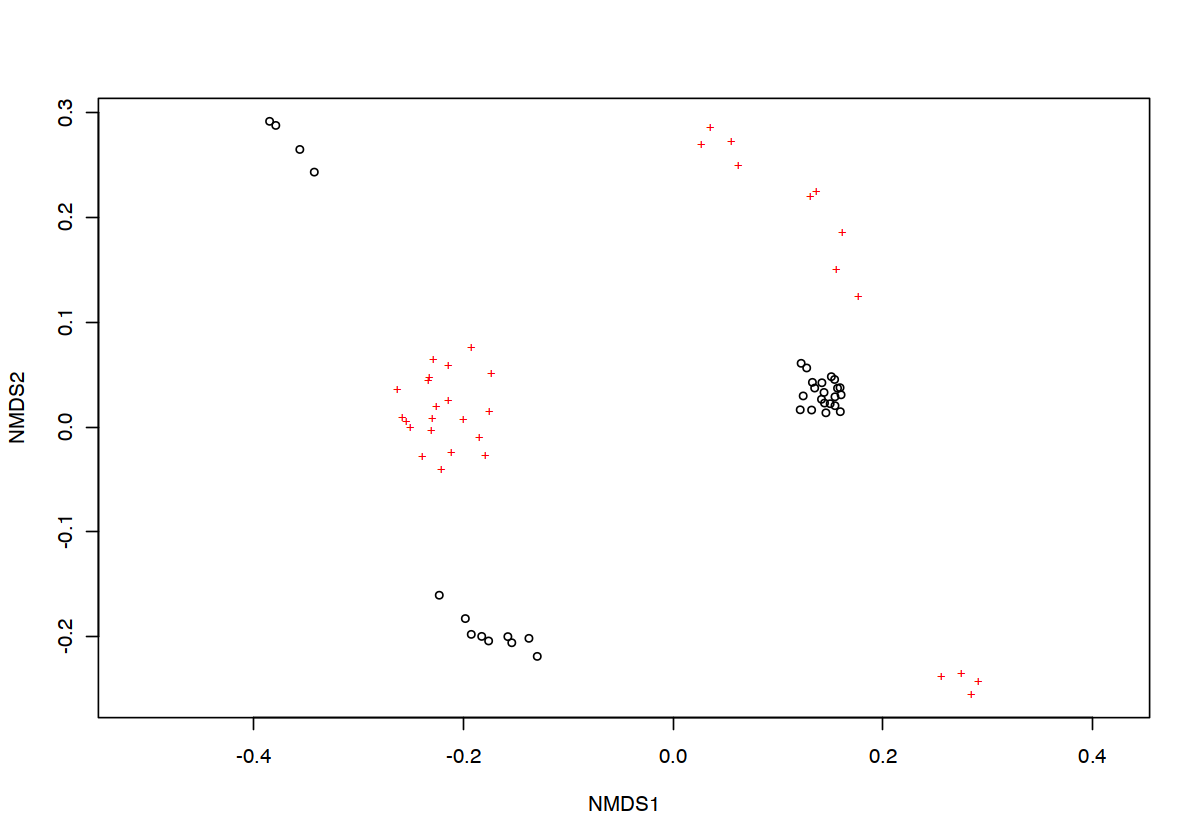

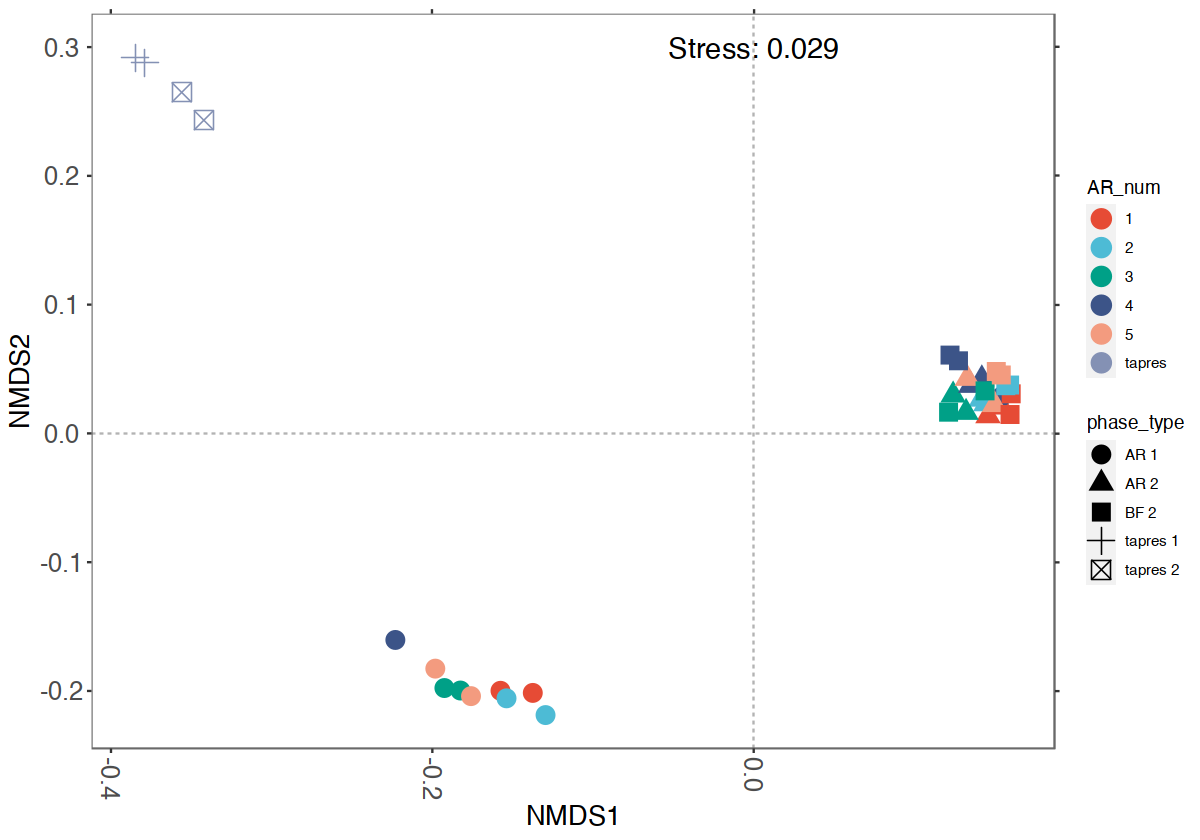

In [24]:
Ordination.model1 <- metaMDS(dist_nmds, distance='bray', k=2, #trymax=1, 
  autotransform=TRUE, noshare=0.1, expand=TRUE, trace=1, plot=FALSE)
stress <- Ordination.model1$stress
metadata_nmds <- metadata_nmds %>% add_column(phase_type = paste(metadata_nmds$type, metadata_nmds$phase))

# Ordination.model1 <- cmdscale((dist_nmds))
plot1 <- ordiplot(Ordination.model1, choices=c(1,2))
sites.long1 <- sites.long(plot1, env.data=metadata_nmds)

options(repr.plot.width = 10, repr.plot.height = 7)
plotgg1 <- ggplot() + 
    geom_vline(xintercept = c(0), color = "grey70", linetype = 2) +
    geom_hline(yintercept = c(0), color = "grey70", linetype = 2) +  
    xlab("NMDS1") +
    ylab("NMDS2") +  
    scale_x_continuous(sec.axis = dup_axis(labels=NULL, name=NULL)) +
    scale_y_continuous(sec.axis = dup_axis(labels=NULL, name=NULL)) +    
    geom_point(data=sites.long1, 
               aes(x=axis1, y=axis2, colour=AR_num, shape=phase_type), 
               size=5) +
    annotate("text", x=0, y=0.3, size= 6, label= paste("Stress:", round(stress, 3))) + 
    # BioR.theme +
    ggsci::scale_colour_npg() +
     theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5, size= 15),
           axis.title.x = element_text(size= 16),
       axis.text.y = element_text( hjust = 0.5, vjust=0.5, size= 15),
       axis.title.y = element_text(size =16), 
       panel.background = element_rect(fill = "white"),panel.border = element_rect(colour = "#696969",size=0.5, fill = "transparent"))

plotgg1


In [25]:
ggsave(paste0(fig_dir, 'MASH_NMDS.pdf'), width=12, height=8)

# Permanova 

In [ ]:
# PERMANOVA
# stag.dist <- vegdist(coverage_norm_nocontrols, method="bray")
metadata_nmds$day <- as.character(metadata_nmds$day)
metadata_nmds$phase <- as.character(metadata_nmds$phase)
# default test by terms
stag.div <- adonis2(dist_nmds ~ type+phase+day+AR, data = metadata_nmds, permutations = 999, method="bray")  #day/phase+AR/type

stag.div

ERROR: Error in qr.fitted(qrhs, G): 'qr' and 'y' must have the same number of rows


In [104]:
#phase 2 only 
# coverage_p1 <- rps2_norm_notap[str_detect(rownames(rps2_norm_notap), "134") | str_detect(rownames(rps2_norm_notap), "162"), ]
# dist_nmds_p2 <- dist2[!(str_detect(dist2$query, "134") | str_detect(dist2$query, "387") | str_detect(dist2$ref, "372") | str_detect(dist2$ref, "387")), ]


dist_nmds_p2 <- dist2 %>% filter(query != "slidecontrol_387" & query != "manifcontrol_387" & ref != "slidecontrol_387" & ref != "manifcontrol_387") %>%
                        filter(query != "control_mock1e8" & query != "control_mock1e10" & ref != "control_mock1e8" & ref != "control_mock1e10") %>%
                        filter(!(str_detect(query, "134") | str_detect(query, "162") | str_detect(ref, "134") | str_detect(ref, "162"))) %>%
                        select(query, ref, distance) %>% pivot_wider(names_from= ref, values_from= distance) 
x <- dist_nmds_p2$query 
rownames(dist_nmds_p2) <- x
dist_nmds_p2 <- dist_nmds_p2 %>% dplyr::select(-c(query))

metadata_nmds_p2 <- metadata %>% filter(sample_id != "control_mock1e10" &sample_id != "control_mock1e8" &sample_id != "slidecontrol_387" &sample_id != "manifcontrol_387" ) %>%
                filter(replicate == "A") %>% filter(phase == 2)

stag.div <- adonis2(dist_nmds_p2 ~ type+day+AR, data = metadata_nmds_p2, permutations = 999, method="bray")
stag.div


Warning message:
“Setting row names on a tibble is deprecated.”


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
type,2,0.348019812,0.731579574,140.205704,0.001
day,1,0.001521391,0.003198146,1.225836,0.478
AR,8,0.113757881,0.239132772,11.457325,0.001
Residual,10,0.012411043,0.026089508,NA,NA
Total,21,0.475710127,1.000000000,NA,NA


In [105]:
#phase 2 only 
# coverage_p1 <- rps2_norm_notap[str_detect(rownames(rps2_norm_notap), "134") | str_detect(rownames(rps2_norm_notap), "162"), ]
# dist_nmds_p2 <- dist2[!(str_detect(dist2$query, "134") | str_detect(dist2$query, "387") | str_detect(dist2$ref, "372") | str_detect(dist2$ref, "387")), ]


dist_nmds_p2 <- dist2 %>% filter(query != "slidecontrol_387" & query != "manifcontrol_387" & ref != "slidecontrol_387" & ref != "manifcontrol_387") %>%
                        filter(query != "control_mock1e8" & query != "control_mock1e10" & ref != "control_mock1e8" & ref != "control_mock1e10") %>%
                        filter(!(str_detect(query, "134") | str_detect(query, "162") | str_detect(ref, "134") | str_detect(ref, "162"))) %>%
                        filter(!(str_detect(query, "tapres")  | str_detect(ref, "tapres"))) %>%
                        select(query, ref, distance) %>% pivot_wider(names_from= ref, values_from= distance) 
x <- dist_nmds_p2$query 
rownames(dist_nmds_p2) <- x
dist_nmds_p2 <- dist_nmds_p2 %>% dplyr::select(-c(query))

metadata_nmds_p2 <- metadata %>% filter(sample_id != "control_mock1e10" &sample_id != "control_mock1e8" &sample_id != "slidecontrol_387" &sample_id != "manifcontrol_387" ) %>%
                filter(replicate == "A") %>% filter(phase == 2) %>% filter(type != "tapres")

stag.div <- adonis2(dist_nmds_p2 ~ type+day+AR, data = metadata_nmds_p2, permutations = 999, method="bray")
stag.div


Warning message:
“Setting row names on a tibble is deprecated.”


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
type,1,0.015070631,0.07792517,9.801575,0.001
day,1,0.001701462,0.00879769,1.106590,0.356
AR,8,0.162788505,0.84172470,13.234214,0.001
Residual,9,0.013838152,0.07155244,NA,NA
Total,19,0.193398751,1.00000000,NA,NA


In [107]:
#phase 1 only 
# coverage_p1 <- rps2_norm_notap[str_detect(rownames(rps2_norm_notap), "134") | str_detect(rownames(rps2_norm_notap), "162"), ]
# dist_nmds_p2 <- dist2[!(str_detect(dist2$query, "134") | str_detect(dist2$query, "387") | str_detect(dist2$ref, "372") | str_detect(dist2$ref, "387")), ]


dist_nmds_p2 <- dist2 %>% filter(query != "slidecontrol_387" & query != "manifcontrol_387" & ref != "slidecontrol_387" & ref != "manifcontrol_387") %>%
                        filter(query != "control_mock1e8" & query != "control_mock1e10" & ref != "control_mock1e8" & ref != "control_mock1e10") %>%
                        filter(!(str_detect(query, "372") | str_detect(query, "387") | str_detect(ref, "372") | str_detect(ref, "387"))) %>%
                        filter(!(str_detect(query, "tapres")  | str_detect(ref, "tapres"))) %>%
                        select(query, ref, distance) %>% pivot_wider(names_from= ref, values_from= distance) 
x <- dist_nmds_p2$query 
rownames(dist_nmds_p2) <- x
dist_nmds_p2 <- dist_nmds_p2 %>% dplyr::select(-c(query))

metadata_nmds_p2 <- metadata %>% filter(sample_id != "control_mock1e10" &sample_id != "control_mock1e8" &sample_id != "slidecontrol_387" &sample_id != "manifcontrol_387" ) %>%
                filter(replicate == "A") %>% filter(phase == 1) %>% filter(type != "tapres")

stag.div <- adonis2(dist_nmds_p2 ~ day+AR, data = metadata_nmds_p2, permutations = 999, method="bray")
stag.div


Warning message:
“Setting row names on a tibble is deprecated.”


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
day,1,0.01453885,0.06867423,1.172445,0.300
AR,4,0.14756689,0.69703168,2.975029,0.001
Residual,4,0.04960183,0.23429409,NA,NA
Total,9,0.21170757,1.00000000,NA,NA
